In [1]:
import pandas as pd
import os
import numpy as np
import pytz
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import pytz as tz
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.signal import butter, filtfilt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
RESPECK_FILE = '../data/bishkek_csr/03_train_ready/respeck/08-05-2025_respeck.csv'
PSG_FILE = '../data/bishkek_csr/03_train_ready/nasal_files/08-05-2025_nasal.csv'
LABELS_FILE = '../data/bishkek_csr/03_train_ready/event_exports/08-05-2025_event_export.csv'
OUTPUT_FILE = './08-05-2025_respeck_features.csv'

# --- Load Data ---
print("Loading data...")

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# respeck_df.set_index('timestamp', inplace=True, drop=False)
print(respeck_df['timestamp'])


psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
print(psg_df['timestamp'])
# psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# labels_df.set_index('timestamp', inplace=True)

Loading data...
0        2025-05-08 00:00:58.562000+06:00
1        2025-05-08 00:00:58.642000+06:00
2        2025-05-08 00:00:58.722000+06:00
3        2025-05-08 00:00:58.802000+06:00
4        2025-05-08 00:00:58.882000+06:00
                       ...               
263419   2025-05-08 05:51:48.255000+06:00
263420   2025-05-08 05:51:48.335000+06:00
263421   2025-05-08 05:51:48.415000+06:00
263422   2025-05-08 05:51:48.495000+06:00
263423   2025-05-08 05:51:48.575000+06:00
Name: timestamp, Length: 263424, dtype: datetime64[ns, Asia/Bishkek]
0                2025-05-07 23:58:33+06:00
1         2025-05-07 23:58:33.010000+06:00
2         2025-05-07 23:58:33.020000+06:00
3         2025-05-07 23:58:33.030000+06:00
4         2025-05-07 23:58:33.040000+06:00
                        ...               
2027795   2025-05-08 05:36:30.950000+06:00
2027796   2025-05-08 05:36:30.960000+06:00
2027797   2025-05-08 05:36:30.970000+06:00
2027798   2025-05-08 05:36:30.980000+06:00
2027799   2025-05-08 05

In [3]:

start_time_respeck = respeck_df['timestamp'].min()
end_time_respeck = respeck_df['timestamp'].max()

start_time_psg = psg_df['timestamp'].min()
end_time_psg = psg_df['timestamp'].max()

overlap_start = max(start_time_respeck, start_time_psg)
overlap_end = min(end_time_respeck, end_time_psg)


print(overlap_start)
print(overlap_end)

respeck_df = respeck_df[(respeck_df['timestamp'] >= overlap_start) & (respeck_df['timestamp'] <= overlap_end)]
psg_df = psg_df[(psg_df['timestamp'] >= overlap_start) & (psg_df['timestamp'] <= overlap_end)]

# Dynamically calculate the sampling rate from the timestamps
time_diffs_ms = respeck_df['alignedTimestamp'].diff().median()
if pd.isna(time_diffs_ms) or time_diffs_ms == 0:

    fs = 1000.0 / time_diffs_ms  # Sampling frequency in Hz
    print(f"    - Calculated sampling rate: {fs:.2f} Hz")

    # Define filter parameters
    lowcut = 0.1   # Lower cutoff frequency in Hz
    highcut = 1.5  # Upper cutoff frequency in Hz
    order = 2      # Filter order (2 is a good choice to avoid distortion)

    try:
        # Design the Butterworth bandpass filter
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        
        respeck_df['original_breathingSignal'] = respeck_df['breathingSignal']

    # 2. Apply the filter and OVERWRITE the 'breathingSignal' column with the clean data
        respeck_df['breathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])

        # # Apply the filter and store it in a NEW column
        # # We keep the original 'breathingSignal' for reference
        # respeck_df['filteredBreathingSignal'] = filtfilt(b, a, respeck_df['breathingSignal'])
    except ValueError as e:
        print(f"  - WARNING: Skipping session. Filter could not be applied. Error: {e}")

2025-05-08 00:00:58.562000+06:00
2025-05-08 05:36:30.990000+06:00


In [4]:
from respiratoryFeatures import *

times = respeck_df['timestamp'].values
bs = respeck_df['breathingSignal'].values
respeck_df['breathingSignal'] = respeck_df['breathingSignal'].ffill()
respeck_df['breathingSignal'] = respeck_df['breathingSignal'].bfill()

cal_timeseries_instantaneous_rr(respeck_df['breathingSignal'])


array([15.96554268, 15.96554268, 15.96554268, ...,  6.72897196,
        6.72897196,  6.72897196])

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk # type: ignore
import pandas as pd
from scipy.integrate import simpson
 
# Parameters
duration = 30  # seconds
sampling_rate = 12  # Hz (samples per second)
frequency = 0.25  # Hz (breaths per second, e.g. 15 breaths/min)
amplitude = 1.0  # peak amplitude
 
# Time vector
t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
 
# Generate sinusoidal signal
signal = amplitude * np.sin(2 * np.pi * frequency * t)

In [6]:
def cal_timeseries_instantaneous_rr(signal):
    """
    Calculate the instantaneous respiratory rate (breaths per minute) from a given respiratory signal.
 
    Parameters:
    - signal (array-like): The respiratory signal data.
 
    Returns:
    - rsp_rate (array-like): The computed respiratory rate over time.
    """
    rsp_rate = nk.rsp_rate(signal, troughs=None, sampling_rate=12, window=10,
                           hop_size=1, method='trough', peak_method='khodadad2018',
                           interpolation_method='monotone_cubic')
    return rsp_rate

In [7]:
cal_timeseries_instantaneous_rr(respeck_df['breathingSignal'])

array([15.96554268, 15.96554268, 15.96554268, ...,  6.72897196,
        6.72897196,  6.72897196])

In [8]:
from calculateContinuousBreathFeatures import *

In [17]:
x = calculate_TS_breathFeatures(times, respeck_df['breathingSignal'].to_numpy())


1


/opt/anaconda3/envs/diss/lib/python3.11/site-packages/neurokit2/rsp/rsp_rvt.py:330: NeuroKitWarning: rsp_rvt(): The next bigger increasing index has a bigger value than the chosen decreasing index, this might be due to very small/noisy breaths or saddle points. Interpolation is skipped for this case.
  warn(


2
3
4
5
6
{'timestamp': array(['2025-05-07T18:00:58.562000000', '2025-05-07T18:00:58.642000000',
       '2025-05-07T18:00:58.722000000', ...,
       '2025-05-07T23:36:30.765000000', '2025-05-07T23:36:30.845000000',
       '2025-05-07T23:36:30.925000000'], dtype='datetime64[ns]'), 'breathingSignal': array([-0.10810959, -0.06934124, -0.03829811, ..., -0.0379971 ,
       -0.04765247, -0.05762402]), 'rr': array([15.96554268, 15.96554268, 15.96554268, ...,  6.72897196,
        6.72897196,  6.72897196]), 'rvt': array([0.12223904, 0.12243002, 0.12278631, ..., 0.02068885, 0.02273975,
       0.02477937]), 'amplitude': array([0.36949679, 0.36949679, 0.36949679, ..., 1.11601434, 1.11601434,
       1.11601434]), 'peak_trough_symmetry': array([0.5       , 0.5       , 0.5       , ..., 0.48148148, 0.48148148,
       0.48148148]), 'rise_decay_symmetry': array([0.51851852, 0.51851852, 0.51851852, ..., 0.27102804, 0.27102804,
       0.27102804]), 'auc_values': array([  3.19276899,   2.57565816,   3.0315

In [22]:
def print_dict_summary(d):
    """
    Prints a readable summary of a dictionary containing arrays or other data.
    """
    print("--- Dictionary Summary ---")
    for key, value in d.items():
        # Get the type of the value
        value_type = type(value).__name__
        
        # Get the length or shape if it's an array/list
        try:
            # For numpy arrays, shape is more informative
            if hasattr(value, 'shape'):
                length_info = f"Shape: {value.shape}"
            else:
                length_info = f"Length: {len(value)}"
        except TypeError:
            length_info = "Not a sequence"

        # Get a small preview of the data
        try:
            # Show first 3 elements
            preview = f"Preview: {value[:3]}"
            # Add ellipsis if the array is longer
            if len(value) > 3:
                preview += " ..."
        except:
            # If slicing isn't possible (e.g., it's a single number)
            preview = f"Value: {value}"

        print(f"{key:<25} | {value_type:<15} | {length_info:<20} | {preview}")
    print("--------------------------")

print_dict_summary(x)

--- Dictionary Summary ---
timestamp                 | ndarray         | Shape: (252278,)     | Preview: ['2025-05-07T18:00:58.562000000' '2025-05-07T18:00:58.642000000'
 '2025-05-07T18:00:58.722000000'] ...
breathingSignal           | ndarray         | Shape: (252278,)     | Preview: [-0.10810959 -0.06934124 -0.03829811] ...
rr                        | ndarray         | Shape: (252278,)     | Preview: [15.96554268 15.96554268 15.96554268] ...
rvt                       | ndarray         | Shape: (252278,)     | Preview: [0.12223904 0.12243002 0.12278631] ...
amplitude                 | ndarray         | Shape: (252278,)     | Preview: [0.36949679 0.36949679 0.36949679] ...
peak_trough_symmetry      | ndarray         | Shape: (252278,)     | Preview: [0.5 0.5 0.5] ...
rise_decay_symmetry       | ndarray         | Shape: (252278,)     | Preview: [0.51851852 0.51851852 0.51851852] ...
auc_values                | ndarray         | Shape: (5591,)       | Preview: [3.19276899 2.57565816 3.03

Calculating features...
1
2
3
4
5
6
{'timestamp': array(['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.083333333',
       '1970-01-01T00:00:00.166666667', ...,
       '1970-01-01T00:04:59.750000000', '1970-01-01T00:04:59.833333333',
       '1970-01-01T00:04:59.916666667'], dtype='datetime64[ns]'), 'breathingSignal': array([ 0.        ,  0.13052619,  0.25881905, ..., -0.38268343,
       -0.25881905, -0.13052619]), 'rr': array([15., 15., 15., ..., 15., 15., 15.]), 'rvt': array([0.44698851, 0.44717286, 0.44753703, ..., 0.47222691, 0.47204059,
       0.47194117]), 'amplitude': array([2., 2., 2., ..., 2., 2., 2.]), 'peak_trough_symmetry': array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]), 'rise_decay_symmetry': array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]), 'auc_values': array([30.55779902, 30.55779902, 30.55779902, 30.55779902, 30.55779902,
       30.55779902, 30.55779902, 30.55779902, 30.55779902, 30.55779902,
       30.55779902, 30.55779902, 30.55779902, 30.55779902, 30.55779902,
       30

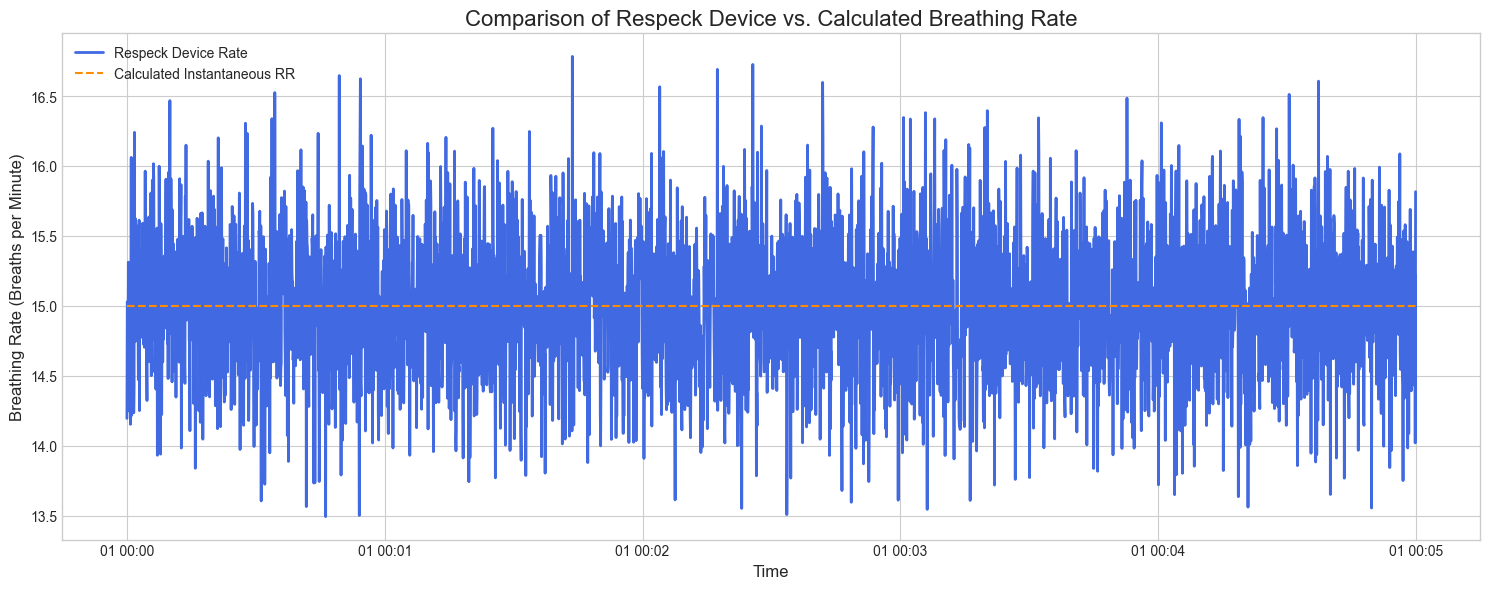

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Assume 'respeck_df' is your loaded DataFrame

# --- Step 1: Call your feature extraction function ---
# The function returns a "flat" dictionary. We'll call it feature_dict.
print("Calculating features...")
feature_dict = calculate_TS_breathFeatures(
    respeck_df['timestamp'].to_numpy(),
    respeck_df['breathingSignal'].to_numpy()
)
print("Feature calculation complete.")


# --- Step 2: Plot directly from the dictionary and the DataFrame ---
# Use a try...except block for robust error handling
try:
    # Extract the 'rr' array from the dictionary
    rr_calculated = feature_dict['rr']

    # --- Create the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 6))

    # Plot the breathing rate from the original Respeck DataFrame
    ax.plot(respeck_df['timestamp'], respeck_df['breathingRate'], label='Respeck Device Rate', color='royalblue', linewidth=2)

    # Plot your calculated 'rr' using the same timestamps from the original DataFrame
    # This works because 'rr' has the same length as the original signal
    ax.plot(respeck_df['timestamp'], rr_calculated, label='Calculated Instantaneous RR', color='darkorange', linestyle='--')

    # Add labels and title
    ax.set_title('Comparison of Respeck Device vs. Calculated Breathing Rate', fontsize=16)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Breathing Rate (Breaths per Minute)', fontsize=12)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

except KeyError as e:
    print(f"\n--- PLOTTING FAILED ---")
    print(f"A required key was not found in the dictionary: {e}")
    print("Please check the keys that were actually returned by your function:")
    if isinstance(feature_dict, dict):
        print("Available keys:", list(feature_dict.keys()))
    else:
        print("The function did not return a dictionary.")

Plotting 'rr' against its sample index...


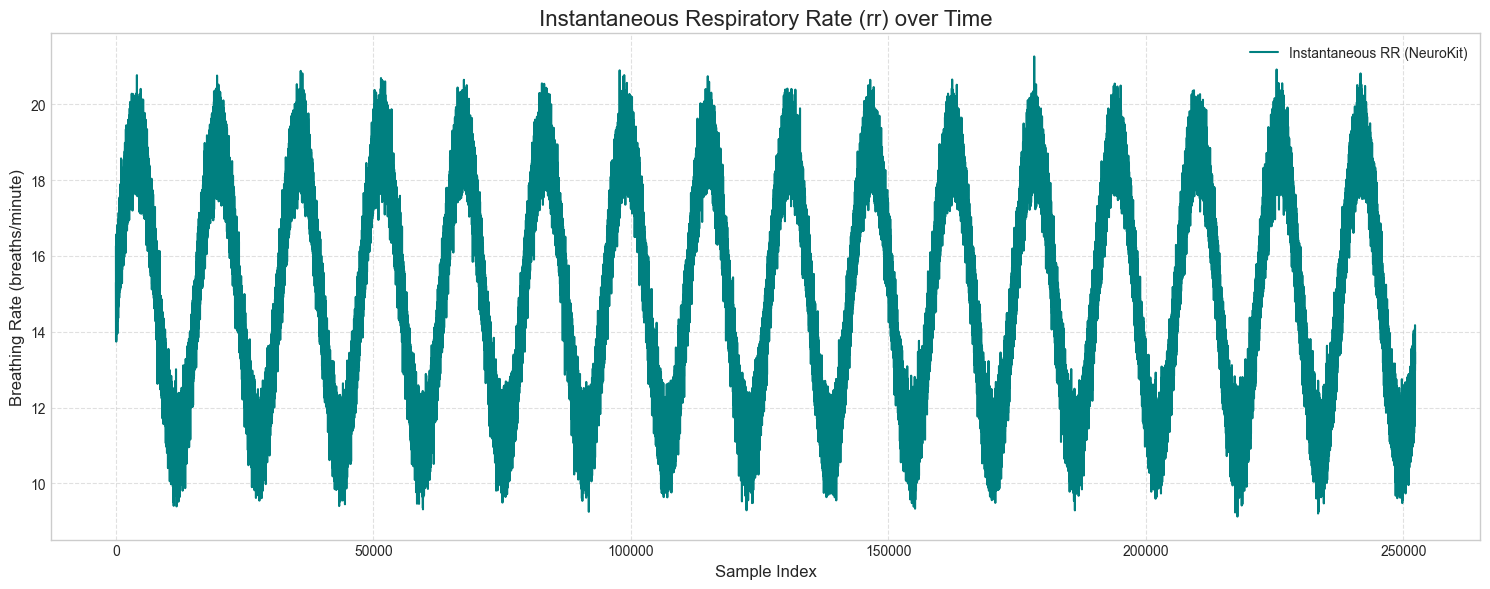

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup sample data that matches your situation ---
# In your code, you would already have the 'x' dictionary.
# This is just for making the example runnable.
rr_length = 252278 
# Create some plausible-looking rr data (a sine wave with noise)
time_points = np.linspace(0, 100, rr_length)
rr_values = 15 + 4 * np.sin(time_points) + np.random.randn(rr_length) * 0.5
x = {'rr': rr_values}
# --- End of setup ---


# --- 2. Create the plot ---
print("Plotting 'rr' against its sample index...")
fig, ax = plt.subplots(figsize=(15, 6))

# The plotting command is very simple. Matplotlib handles the X-axis.
ax.plot(
    x['rr'],  # Just provide the Y-axis data
    label='Instantaneous RR (NeuroKit)',
    color='teal'
)

# --- 3. Add labels to make the plot understandable ---
ax.set_title('Instantaneous Respiratory Rate (rr) over Time', fontsize=16)
ax.set_xlabel('Sample Index', fontsize=12) # The X-axis is the position in the array
ax.set_ylabel('Breathing Rate (breaths/minute)', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Use tight_layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

In [ ]:
print("\nStep 3: Generating the comparison plot...")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# --- Plot 1: The continuous 'rr' from NeuroKit as a LINE ---
ax.plot(
    respeck_df['timestamp'], 
    x['rr'].tolist(), 
    label='Instantaneous RR (NeuroKit)', 
    color='dodgerblue', 
    linewidth=2,
    alpha=0.8
)

# --- Plot 2: The sparse 'breathingRate' from Respeck as DOTS ---
# A scatter plot is perfect for this, as it automatically ignores NaN values
ax.scatter(
    respeck_df['timestamp'], 
    respeck_df['breathingRate'], 
    label='Respeck Detected Breath Event', 
    color='red', 
    marker='o', 
    s=60,  # Size of the markers
    zorder=5 # zorder ensures the dots are drawn on top of the line
)

# --- Formatting the plot to make it readable ---
ax.set_title('Comparison: NeuroKit Instantaneous RR vs. Respeck Breath Events', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Breathing Rate (breaths/minute)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve the formatting of the time axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)
fig.tight_layout()

# Show the plot
plt.show()
print("\nPlot displayed.")

Shape of timestamps: (3600,)


NameError: name 'window_features' is not defined